# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
#copula_pv = pv.Bicop(family=pv.BicopFamily.indep)
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_83496/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_83496/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_83496/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    "RW2": { "tau_a": 1.2, "tau_b": 0.7 },  #E[λ_T] = sehr groß  (smooth but not stiff)
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [8]:
output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=100,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/100 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=ord

[1/100] train=36.5118  val=37.3303  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0510  σmin=0.0510  σmax=0.0510mean param=tensor([ 9.9900,  1.6511,  1.6511,  1.6511,  1.6511,  1.6511,  1.6511,  1.6511,
         1.6511,  1.6508,  1.6411,  1.6411, 10.0100,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6511,  1.6511,  1.6511,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)
[2/100] train=35.8001  val=36.8683  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0520  σmin=0.0520  σmax=0.0520mean param=tensor([ 9.9973,  1.6437,  1.6437,  1.6437,  1.6438,  1.6458,  1.6563,  1.6599,
         1.6606,  1.6573,  1.6411,  1.6411, 10.0097,  1.6313,  1.6313,  1.6313,
         1.6315,  1.6367,  1.6610,  1.6611,  1.6610,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


  4%|▍         | 4/100 [00:00<00:20,  4.68it/s]

[3/100] train=38.2045  val=36.4115  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0530  σmin=0.0530  σmax=0.0530mean param=tensor([10.0028,  1.6382,  1.6382,  1.6382,  1.6383,  1.6431,  1.6633,  1.6690,
         1.6702,  1.6623,  1.6411,  1.6411, 10.0117,  1.6293,  1.6293,  1.6292,
         1.6296,  1.6406,  1.6705,  1.6708,  1.6708,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)
[4/100] train=38.1428  val=35.9571  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0540  σmin=0.0540  σmax=0.0540mean param=tensor([10.0078,  1.6332,  1.6332,  1.6332,  1.6334,  1.6413,  1.6709,  1.6783,
         1.6797,  1.6689,  1.6411,  1.6411, 10.0106,  1.6303,  1.6304,  1.6302,
         1.6309,  1.6467,  1.6802,  1.6806,  1.6805,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


  6%|▌         | 6/100 [00:01<00:18,  5.12it/s]

[5/100] train=32.7277  val=35.5057  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0550  σmin=0.0550  σmax=0.0550mean param=tensor([10.0133,  1.6277,  1.6277,  1.6276,  1.6280,  1.6390,  1.6783,  1.6874,
         1.6891,  1.6762,  1.6411,  1.6411, 10.0087,  1.6321,  1.6323,  1.6320,
         1.6329,  1.6535,  1.6899,  1.6903,  1.6902,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)
[6/100] train=32.2262  val=35.0554  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0561  σmin=0.0561  σmax=0.0561mean param=tensor([10.0175,  1.6235,  1.6235,  1.6234,  1.6238,  1.6384,  1.6864,  1.6966,
         1.6986,  1.6826,  1.6411,  1.6411, 10.0059,  1.6349,  1.6351,  1.6348,
         1.6358,  1.6608,  1.6996,  1.7000,  1.6999,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


  8%|▊         | 8/100 [00:01<00:16,  5.46it/s]

[7/100] train=35.2858  val=34.6053  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0571  σmin=0.0571  σmax=0.0571mean param=tensor([10.0193,  1.6216,  1.6217,  1.6216,  1.6220,  1.6404,  1.6951,  1.7061,
         1.7081,  1.6897,  1.6411,  1.6411, 10.0052,  1.6355,  1.6357,  1.6355,
         1.6366,  1.6666,  1.7090,  1.7096,  1.7095,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)
[8/100] train=34.5890  val=34.1553  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0582  σmin=0.0582  σmax=0.0582mean param=tensor([10.0200,  1.6210,  1.6210,  1.6209,  1.6215,  1.6437,  1.7041,  1.7157,
         1.7176,  1.6973,  1.6411,  1.6411, 10.0033,  1.6373,  1.6375,  1.6373,
         1.6386,  1.6733,  1.7185,  1.7191,  1.7191,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 10%|█         | 10/100 [00:02<00:17,  5.13it/s]

[9/100] train=35.4974  val=33.7049  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0593  σmin=0.0593  σmax=0.0593mean param=tensor([10.0190,  1.6219,  1.6219,  1.6218,  1.6224,  1.6483,  1.7134,  1.7253,
         1.7272,  1.7041,  1.6411,  1.6411, 10.0008,  1.6397,  1.6400,  1.6398,
         1.6412,  1.6804,  1.7280,  1.7287,  1.7287,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)
[10/100] train=33.3687  val=33.2555  S_train=4 S_val=16 lr=[0.01, 0.02]σ̄=0.0604  σmin=0.0604  σmax=0.0604mean param=tensor([10.0197,  1.6211,  1.6212,  1.6212,  1.6218,  1.6514,  1.7222,  1.7348,
         1.7366,  1.7101,  1.6411,  1.6411,  9.9996,  1.6409,  1.6412,  1.6410,
         1.6426,  1.6868,  1.7373,  1.7382,  1.7382,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 11%|█         | 11/100 [00:02<00:17,  4.95it/s]

[11/100] train=34.6011  val=32.8063  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0616  σmin=0.0615  σmax=0.0616mean param=tensor([10.0192,  1.6215,  1.6216,  1.6216,  1.6223,  1.6556,  1.7312,  1.7443,
         1.7461,  1.7173,  1.6411,  1.6411,  9.9989,  1.6415,  1.6418,  1.6416,
         1.6433,  1.6928,  1.7466,  1.7476,  1.7477,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 12%|█▏        | 12/100 [00:02<00:18,  4.80it/s]

[12/100] train=33.9105  val=32.3562  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0627  σmin=0.0627  σmax=0.0627mean param=tensor([10.0182,  1.6224,  1.6224,  1.6225,  1.6233,  1.6603,  1.7404,  1.7538,
         1.7555,  1.7248,  1.6411,  1.6411, 10.0001,  1.6402,  1.6406,  1.6404,
         1.6423,  1.6975,  1.7556,  1.7569,  1.7572,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 13%|█▎        | 13/100 [00:02<00:18,  4.68it/s]

[13/100] train=33.6196  val=31.9062  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0639  σmin=0.0639  σmax=0.0639mean param=tensor([10.0170,  1.6236,  1.6236,  1.6237,  1.6246,  1.6652,  1.7497,  1.7633,
         1.7649,  1.7316,  1.6411,  1.6411, 10.0036,  1.6367,  1.6371,  1.6368,
         1.6389,  1.6996,  1.7640,  1.7660,  1.7666,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 14%|█▍        | 14/100 [00:02<00:18,  4.60it/s]

[14/100] train=33.9999  val=31.4566  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0651  σmin=0.0651  σmax=0.0651mean param=tensor([10.0169,  1.6236,  1.6236,  1.6237,  1.6248,  1.6692,  1.7585,  1.7725,
         1.7741,  1.7377,  1.6411,  1.6411, 10.0085,  1.6317,  1.6322,  1.6319,
         1.6341,  1.7001,  1.7719,  1.7749,  1.7759,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 15%|█▌        | 15/100 [00:03<00:18,  4.57it/s]

[15/100] train=31.7115  val=31.0074  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0663  σmin=0.0663  σmax=0.0663mean param=tensor([10.0172,  1.6233,  1.6233,  1.6234,  1.6246,  1.6729,  1.7672,  1.7817,
         1.7833,  1.7442,  1.6411,  1.6411, 10.0143,  1.6258,  1.6263,  1.6261,
         1.6283,  1.6994,  1.7795,  1.7837,  1.7851,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 16%|█▌        | 16/100 [00:03<00:18,  4.52it/s]

[16/100] train=29.5246  val=30.5589  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0676  σmin=0.0676  σmax=0.0676mean param=tensor([10.0182,  1.6222,  1.6222,  1.6224,  1.6237,  1.6759,  1.7756,  1.7907,
         1.7923,  1.7500,  1.6411,  1.6411, 10.0209,  1.6192,  1.6197,  1.6194,
         1.6218,  1.6976,  1.7868,  1.7923,  1.7943,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 17%|█▋        | 17/100 [00:03<00:19,  4.35it/s]

[17/100] train=30.5972  val=30.1112  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0688  σmin=0.0688  σmax=0.0688mean param=tensor([10.0196,  1.6207,  1.6207,  1.6209,  1.6224,  1.6787,  1.7838,  1.7995,
         1.8013,  1.7560,  1.6411,  1.6411, 10.0278,  1.6122,  1.6128,  1.6125,
         1.6150,  1.6954,  1.7939,  1.8008,  1.8034,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 18%|█▊        | 18/100 [00:03<00:18,  4.47it/s]

[18/100] train=31.7143  val=29.6637  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0701  σmin=0.0701  σmax=0.0701mean param=tensor([10.0214,  1.6189,  1.6189,  1.6191,  1.6207,  1.6811,  1.7919,  1.8082,
         1.8102,  1.7625,  1.6411,  1.6411, 10.0334,  1.6065,  1.6070,  1.6068,
         1.6093,  1.6946,  1.8015,  1.8095,  1.8126,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 19%|█▉        | 19/100 [00:04<00:20,  3.98it/s]

[19/100] train=28.3304  val=29.2170  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0715  σmin=0.0715  σmax=0.0715mean param=tensor([10.0234,  1.6168,  1.6168,  1.6170,  1.6187,  1.6833,  1.7998,  1.8169,
         1.8190,  1.7685,  1.6411,  1.6411, 10.0400,  1.5999,  1.6004,  1.6002,
         1.6028,  1.6924,  1.8085,  1.8179,  1.8217,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 20%|██        | 20/100 [00:04<00:19,  4.19it/s]

[20/100] train=29.0882  val=28.7713  S_train=8 S_val=16 lr=[0.01, 0.02]σ̄=0.0728  σmin=0.0728  σmax=0.0728mean param=tensor([10.0258,  1.6144,  1.6144,  1.6146,  1.6165,  1.6853,  1.8077,  1.8254,
         1.8278,  1.7739,  1.6411,  1.6411, 10.0465,  1.5933,  1.5939,  1.5937,
         1.5964,  1.6904,  1.8155,  1.8262,  1.8307,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 21%|██        | 21/100 [00:04<00:20,  3.81it/s]

[21/100] train=27.9933  val=28.3253  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0742  σmin=0.0742  σmax=0.0742mean param=tensor([10.0280,  1.6121,  1.6121,  1.6123,  1.6143,  1.6874,  1.8155,  1.8338,
         1.8365,  1.7800,  1.6411,  1.6411, 10.0505,  1.5893,  1.5898,  1.5896,
         1.5924,  1.6908,  1.8231,  1.8348,  1.8398,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 22%|██▏       | 22/100 [00:05<00:21,  3.63it/s]

[22/100] train=28.8078  val=27.8788  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0756  σmin=0.0756  σmax=0.0756mean param=tensor([10.0291,  1.6109,  1.6110,  1.6112,  1.6134,  1.6905,  1.8236,  1.8423,
         1.8452,  1.7866,  1.6411,  1.6411, 10.0527,  1.5870,  1.5875,  1.5874,
         1.5903,  1.6929,  1.8311,  1.8434,  1.8489,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 23%|██▎       | 23/100 [00:05<00:22,  3.36it/s]

[23/100] train=26.8153  val=27.4320  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0770  σmin=0.0770  σmax=0.0770mean param=tensor([10.0311,  1.6087,  1.6089,  1.6091,  1.6114,  1.6927,  1.8312,  1.8505,
         1.8538,  1.7938,  1.6411,  1.6411, 10.0529,  1.5866,  1.5872,  1.5871,
         1.5901,  1.6967,  1.8396,  1.8522,  1.8580,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 24%|██▍       | 24/100 [00:05<00:24,  3.11it/s]

[24/100] train=27.4908  val=26.9851  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0784  σmin=0.0784  σmax=0.0784mean param=tensor([10.0324,  1.6074,  1.6076,  1.6078,  1.6102,  1.6956,  1.8391,  1.8587,
         1.8623,  1.8009,  1.6411,  1.6411, 10.0520,  1.5873,  1.5879,  1.5878,
         1.5910,  1.7014,  1.8484,  1.8611,  1.8671,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 25%|██▌       | 25/100 [00:06<00:24,  3.04it/s]

[25/100] train=27.3729  val=26.5383  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0799  σmin=0.0799  σmax=0.0799mean param=tensor([10.0345,  1.6052,  1.6054,  1.6056,  1.6082,  1.6977,  1.8465,  1.8667,
         1.8707,  1.8074,  1.6411,  1.6411, 10.0509,  1.5883,  1.5890,  1.5889,
         1.5921,  1.7063,  1.8572,  1.8699,  1.8762,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 26%|██▌       | 26/100 [00:06<00:24,  3.03it/s]

[26/100] train=26.2854  val=26.0916  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0814  σmin=0.0814  σmax=0.0814mean param=tensor([10.0362,  1.6033,  1.6036,  1.6038,  1.6065,  1.7001,  1.8540,  1.8746,
         1.8790,  1.8144,  1.6411,  1.6411, 10.0484,  1.5906,  1.5913,  1.5913,
         1.5946,  1.7124,  1.8662,  1.8788,  1.8853,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 27%|██▋       | 27/100 [00:06<00:25,  2.92it/s]

[27/100] train=26.1882  val=25.6450  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0829  σmin=0.0829  σmax=0.0829mean param=tensor([10.0374,  1.6020,  1.6023,  1.6025,  1.6054,  1.7031,  1.8617,  1.8825,
         1.8872,  1.8208,  1.6411,  1.6411, 10.0456,  1.5932,  1.5940,  1.5940,
         1.5974,  1.7186,  1.8754,  1.8877,  1.8944,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 28%|██▊       | 28/100 [00:07<00:25,  2.86it/s]

[28/100] train=25.8841  val=25.1989  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0845  σmin=0.0845  σmax=0.0845mean param=tensor([10.0381,  1.6012,  1.6015,  1.6017,  1.6047,  1.7065,  1.8694,  1.8904,
         1.8954,  1.8277,  1.6411,  1.6411, 10.0430,  1.5956,  1.5964,  1.5964,
         1.5999,  1.7247,  1.8843,  1.8964,  1.9035,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 29%|██▉       | 29/100 [00:07<00:23,  3.05it/s]

[29/100] train=24.3357  val=24.7532  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0861  σmin=0.0860  σmax=0.0861mean param=tensor([10.0395,  1.5997,  1.6000,  1.6002,  1.6033,  1.7092,  1.8768,  1.8980,
         1.9034,  1.8340,  1.6411,  1.6411, 10.0423,  1.5962,  1.5970,  1.5971,
         1.6006,  1.7290,  1.8925,  1.9049,  1.9124,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 30%|███       | 30/100 [00:07<00:22,  3.10it/s]

[30/100] train=27.2633  val=24.3077  S_train=16 S_val=16 lr=[0.01, 0.02]σ̄=0.0877  σmin=0.0877  σmax=0.0877mean param=tensor([10.0416,  1.5975,  1.5978,  1.5980,  1.6013,  1.7112,  1.8838,  1.9053,
         1.9113,  1.8408,  1.6411,  1.6411, 10.0419,  1.5964,  1.5973,  1.5974,
         1.6010,  1.7330,  1.9005,  1.9132,  1.9213,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 31%|███       | 31/100 [00:08<00:25,  2.74it/s]

[31/100] train=24.6013  val=23.8622  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.0893  σmin=0.0893  σmax=0.0893mean param=tensor([10.0429,  1.5960,  1.5963,  1.5966,  1.6000,  1.7140,  1.8910,  1.9127,
         1.9192,  1.8474,  1.6411,  1.6411, 10.0418,  1.5964,  1.5973,  1.5974,
         1.6010,  1.7366,  1.9084,  1.9214,  1.9301,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 32%|███▏      | 32/100 [00:08<00:26,  2.54it/s]

[32/100] train=24.7442  val=23.4167  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.0910  σmin=0.0910  σmax=0.0910mean param=tensor([10.0437,  1.5951,  1.5954,  1.5957,  1.5993,  1.7172,  1.8983,  1.9201,
         1.9270,  1.8545,  1.6411,  1.6411, 10.0428,  1.5952,  1.5961,  1.5962,
         1.5999,  1.7392,  1.9157,  1.9294,  1.9389,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 33%|███▎      | 33/100 [00:09<00:29,  2.29it/s]

[33/100] train=23.5987  val=22.9712  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.0927  σmin=0.0927  σmax=0.0927mean param=tensor([10.0442,  1.5945,  1.5948,  1.5951,  1.5989,  1.7207,  1.9057,  1.9273,
         1.9347,  1.8618,  1.6411,  1.6411, 10.0443,  1.5936,  1.5946,  1.5947,
         1.5985,  1.7413,  1.9228,  1.9372,  1.9475,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 34%|███▍      | 34/100 [00:09<00:34,  1.90it/s]

[34/100] train=23.1152  val=22.5258  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.0944  σmin=0.0944  σmax=0.0944mean param=tensor([10.0446,  1.5939,  1.5943,  1.5945,  1.5985,  1.7243,  1.9130,  1.9345,
         1.9424,  1.8685,  1.6411,  1.6411, 10.0463,  1.5915,  1.5925,  1.5926,
         1.5964,  1.7429,  1.9296,  1.9448,  1.9561,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 35%|███▌      | 35/100 [00:10<00:37,  1.73it/s]

[35/100] train=22.6260  val=22.0809  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.0962  σmin=0.0962  σmax=0.0962mean param=tensor([10.0450,  1.5934,  1.5937,  1.5939,  1.5981,  1.7279,  1.9201,  1.9414,
         1.9499,  1.8757,  1.6411,  1.6411, 10.0489,  1.5888,  1.5897,  1.5898,
         1.5938,  1.7438,  1.9361,  1.9522,  1.9646,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 36%|███▌      | 36/100 [00:11<00:40,  1.58it/s]

[36/100] train=22.8318  val=21.6365  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.0980  σmin=0.0980  σmax=0.0980mean param=tensor([10.0458,  1.5924,  1.5927,  1.5929,  1.5973,  1.7310,  1.9270,  1.9482,
         1.9574,  1.8827,  1.6411,  1.6411, 10.0521,  1.5854,  1.5864,  1.5865,
         1.5905,  1.7441,  1.9422,  1.9595,  1.9731,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 37%|███▋      | 37/100 [00:12<00:40,  1.57it/s]

[37/100] train=21.6633  val=21.1923  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.0998  σmin=0.0998  σmax=0.0998mean param=tensor([10.0468,  1.5912,  1.5916,  1.5917,  1.5963,  1.7340,  1.9338,  1.9549,
         1.9647,  1.8899,  1.6411,  1.6411, 10.0556,  1.5818,  1.5828,  1.5829,
         1.5870,  1.7440,  1.9481,  1.9666,  1.9815,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 38%|███▊      | 38/100 [00:12<00:41,  1.48it/s]

[38/100] train=19.9297  val=20.7487  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.1017  σmin=0.1017  σmax=0.1017mean param=tensor([10.0483,  1.5896,  1.5899,  1.5900,  1.5948,  1.7364,  1.9402,  1.9613,
         1.9719,  1.8977,  1.6411,  1.6411, 10.0592,  1.5780,  1.5790,  1.5791,
         1.5833,  1.7438,  1.9539,  1.9735,  1.9898,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 39%|███▉      | 39/100 [00:13<00:45,  1.35it/s]

[39/100] train=20.4535  val=20.3055  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.1036  σmin=0.1036  σmax=0.1036mean param=tensor([10.0496,  1.5881,  1.5885,  1.5886,  1.5936,  1.7391,  1.9466,  1.9676,
         1.9790,  1.9053,  1.6411,  1.6411, 10.0618,  1.5753,  1.5762,  1.5764,
         1.5806,  1.7446,  1.9600,  1.9806,  1.9981,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 40%|████      | 40/100 [00:14<00:52,  1.15it/s]

[40/100] train=20.1854  val=19.8628  S_train=32 S_val=16 lr=[0.01, 0.02]σ̄=0.1055  σmin=0.1055  σmax=0.1055mean param=tensor([10.0514,  1.5862,  1.5866,  1.5866,  1.5918,  1.7413,  1.9527,  1.9737,
         1.9859,  1.9134,  1.6411,  1.6411, 10.0635,  1.5734,  1.5743,  1.5745,
         1.5789,  1.7462,  1.9663,  1.9876,  2.0064,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 41%|████      | 41/100 [00:16<01:04,  1.10s/it]

[41/100] train=20.2957  val=19.4202  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1075  σmin=0.1074  σmax=0.1075mean param=tensor([10.0521,  1.5852,  1.5857,  1.5856,  1.5910,  1.7444,  1.9591,  1.9797,
         1.9927,  1.9219,  1.6411,  1.6411, 10.0646,  1.5722,  1.5731,  1.5733,
         1.5778,  1.7484,  1.9727,  1.9946,  2.0146,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 42%|████▏     | 42/100 [00:18<01:14,  1.29s/it]

[42/100] train=20.8462  val=18.9778  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1095  σmin=0.1094  σmax=0.1095mean param=tensor([10.0526,  1.5845,  1.5851,  1.5849,  1.5906,  1.7477,  1.9655,  1.9857,
         1.9995,  1.9305,  1.6411,  1.6411, 10.0653,  1.5712,  1.5721,  1.5724,
         1.5769,  1.7509,  1.9792,  2.0015,  2.0228,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 43%|████▎     | 43/100 [00:19<01:15,  1.32s/it]

[43/100] train=19.2263  val=18.5361  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1115  σmin=0.1115  σmax=0.1115mean param=tensor([10.0535,  1.5834,  1.5840,  1.5837,  1.5897,  1.7505,  1.9715,  1.9913,
         2.0061,  1.9389,  1.6411,  1.6411, 10.0659,  1.5704,  1.5714,  1.5716,
         1.5763,  1.7535,  1.9856,  2.0084,  2.0310,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 44%|████▍     | 44/100 [00:20<01:06,  1.19s/it]

[44/100] train=17.7664  val=18.0952  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1136  σmin=0.1135  σmax=0.1136mean param=tensor([10.0550,  1.5817,  1.5823,  1.5819,  1.5881,  1.7527,  1.9772,  1.9967,
         2.0125,  1.9473,  1.6411,  1.6411, 10.0665,  1.5696,  1.5706,  1.5708,
         1.5756,  1.7560,  1.9919,  2.0152,  2.0392,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 45%|████▌     | 45/100 [00:21<00:59,  1.08s/it]

[45/100] train=17.9136  val=17.6552  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1157  σmin=0.1156  σmax=0.1157mean param=tensor([10.0570,  1.5795,  1.5801,  1.5797,  1.5861,  1.7544,  1.9824,  2.0017,
         2.0188,  1.9555,  1.6411,  1.6411, 10.0664,  1.5694,  1.5703,  1.5706,
         1.5756,  1.7591,  1.9984,  2.0219,  2.0473,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 46%|████▌     | 46/100 [00:22<00:53,  1.00it/s]

[46/100] train=18.4369  val=17.2160  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1178  σmin=0.1178  σmax=0.1179mean param=tensor([10.0594,  1.5769,  1.5776,  1.5771,  1.5838,  1.7557,  1.9874,  2.0066,
         2.0249,  1.9639,  1.6411,  1.6411, 10.0661,  1.5695,  1.5704,  1.5707,
         1.5758,  1.7625,  2.0049,  2.0286,  2.0553,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 47%|████▋     | 47/100 [00:22<00:49,  1.08it/s]

[47/100] train=17.1695  val=16.7778  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1200  σmin=0.1200  σmax=0.1200mean param=tensor([10.0625,  1.5736,  1.5743,  1.5738,  1.5806,  1.7562,  1.9918,  2.0110,
         2.0308,  1.9723,  1.6411,  1.6411, 10.0651,  1.5703,  1.5711,  1.5714,
         1.5767,  1.7664,  2.0115,  2.0353,  2.0634,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 48%|████▊     | 48/100 [00:23<00:45,  1.13it/s]

[48/100] train=17.3871  val=16.3400  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1222  σmin=0.1222  σmax=0.1223mean param=tensor([10.0655,  1.5704,  1.5711,  1.5706,  1.5775,  1.7567,  1.9962,  2.0152,
         2.0365,  1.9805,  1.6411,  1.6411, 10.0648,  1.5704,  1.5711,  1.5715,
         1.5768,  1.7697,  2.0178,  2.0418,  2.0714,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 49%|████▉     | 49/100 [00:24<00:43,  1.18it/s]

[49/100] train=16.2901  val=15.9029  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1245  σmin=0.1244  σmax=0.1245mean param=tensor([10.0687,  1.5669,  1.5676,  1.5671,  1.5742,  1.7570,  2.0003,  2.0192,
         2.0421,  1.9892,  1.6411,  1.6411, 10.0641,  1.5709,  1.5715,  1.5719,
         1.5773,  1.7732,  2.0240,  2.0482,  2.0793,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 50%|█████     | 50/100 [00:25<00:41,  1.21it/s]

[50/100] train=15.9876  val=15.4664  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1268  σmin=0.1267  σmax=0.1268mean param=tensor([10.0715,  1.5639,  1.5645,  1.5641,  1.5713,  1.7577,  2.0044,  2.0231,
         2.0475,  1.9978,  1.6411,  1.6411, 10.0640,  1.5708,  1.5713,  1.5718,
         1.5773,  1.7762,  2.0299,  2.0544,  2.0871,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 51%|█████     | 51/100 [00:26<00:43,  1.13it/s]

[51/100] train=16.1470  val=15.0300  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1291  σmin=0.1290  σmax=0.1292mean param=tensor([10.0733,  1.5618,  1.5625,  1.5620,  1.5694,  1.7593,  2.0089,  2.0270,
         2.0530,  2.0064,  1.6411,  1.6411, 10.0642,  1.5703,  1.5708,  1.5712,
         1.5769,  1.7787,  2.0355,  2.0604,  2.0949,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 52%|█████▏    | 52/100 [00:27<00:43,  1.09it/s]

[52/100] train=14.7335  val=14.5938  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1315  σmin=0.1314  σmax=0.1315mean param=tensor([10.0741,  1.5607,  1.5613,  1.5609,  1.5684,  1.7617,  2.0136,  2.0310,
         2.0584,  2.0152,  1.6411,  1.6411, 10.0647,  1.5695,  1.5700,  1.5704,
         1.5763,  1.7810,  2.0408,  2.0662,  2.1026,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 53%|█████▎    | 53/100 [00:28<00:44,  1.05it/s]

[53/100] train=14.8314  val=14.1583  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1339  σmin=0.1338  σmax=0.1339mean param=tensor([10.0746,  1.5599,  1.5605,  1.5601,  1.5678,  1.7645,  2.0184,  2.0349,
         2.0637,  2.0239,  1.6411,  1.6411, 10.0649,  1.5691,  1.5695,  1.5700,
         1.5759,  1.7835,  2.0461,  2.0719,  2.1102,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 54%|█████▍    | 54/100 [00:29<00:44,  1.04it/s]

[54/100] train=13.5932  val=13.7234  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1364  σmin=0.1363  σmax=0.1364mean param=tensor([10.0746,  1.5596,  1.5602,  1.5598,  1.5676,  1.7677,  2.0233,  2.0387,
         2.0690,  2.0331,  1.6411,  1.6411, 10.0640,  1.5696,  1.5700,  1.5705,
         1.5766,  1.7869,  2.0517,  2.0777,  2.1179,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 55%|█████▌    | 55/100 [00:30<00:44,  1.02it/s]

[55/100] train=14.6215  val=13.2889  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1388  σmin=0.1388  σmax=0.1389mean param=tensor([10.0739,  1.5599,  1.5606,  1.5602,  1.5682,  1.7716,  2.0285,  2.0426,
         2.0742,  2.0426,  1.6411,  1.6411, 10.0631,  1.5702,  1.5705,  1.5711,
         1.5773,  1.7904,  2.0573,  2.0833,  2.1255,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 56%|█████▌    | 56/100 [00:31<00:46,  1.06s/it]

[56/100] train=12.9535  val=12.8558  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1414  σmin=0.1413  σmax=0.1414mean param=tensor([10.0740,  1.5594,  1.5601,  1.5597,  1.5678,  1.7746,  2.0331,  2.0461,
         2.0793,  2.0517,  1.6411,  1.6411, 10.0611,  1.5719,  1.5722,  1.5728,
         1.5791,  1.7948,  2.0631,  2.0890,  2.1330,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 57%|█████▋    | 57/100 [00:32<00:44,  1.03s/it]

[57/100] train=12.4455  val=12.4233  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1440  σmin=0.1439  σmax=0.1440mean param=tensor([10.0739,  1.5591,  1.5598,  1.5595,  1.5677,  1.7777,  2.0377,  2.0495,
         2.0843,  2.0606,  1.6411,  1.6411, 10.0595,  1.5731,  1.5734,  1.5740,
         1.5805,  1.7988,  2.0687,  2.0946,  2.1405,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 58%|█████▊    | 58/100 [00:33<00:41,  1.01it/s]

[58/100] train=12.8023  val=11.9912  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1466  σmin=0.1465  σmax=0.1466mean param=tensor([10.0735,  1.5591,  1.5598,  1.5595,  1.5679,  1.7811,  2.0422,  2.0528,
         2.0892,  2.0691,  1.6411,  1.6411, 10.0583,  1.5738,  1.5741,  1.5748,
         1.5814,  1.8024,  2.0740,  2.1000,  2.1480,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 59%|█████▉    | 59/100 [00:34<00:40,  1.00it/s]

[59/100] train=12.3631  val=11.5591  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1492  σmin=0.1491  σmax=0.1493mean param=tensor([10.0725,  1.5597,  1.5603,  1.5601,  1.5685,  1.7849,  2.0468,  2.0560,
         2.0940,  2.0776,  1.6411,  1.6411, 10.0586,  1.5732,  1.5735,  1.5742,
         1.5808,  1.8045,  2.0786,  2.1050,  2.1553,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 60%|██████    | 60/100 [00:35<00:37,  1.08it/s]

[60/100] train=11.6629  val=11.1264  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1520  σmin=0.1518  σmax=0.1520mean param=tensor([10.0693,  1.5624,  1.5630,  1.5628,  1.5715,  1.7906,  2.0524,  2.0595,
         2.0989,  2.0864,  1.6411,  1.6411, 10.0603,  1.5710,  1.5714,  1.5720,
         1.5788,  1.8051,  2.0825,  2.1097,  2.1626,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 61%|██████    | 61/100 [00:36<00:35,  1.08it/s]

[61/100] train=10.9515  val=10.6941  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1547  σmin=0.1546  σmax=0.1548mean param=tensor([10.0656,  1.5657,  1.5663,  1.5661,  1.5749,  1.7969,  2.0582,  2.0631,
         2.1038,  2.0950,  1.6411,  1.6411, 10.0627,  1.5683,  1.5687,  1.5693,
         1.5762,  1.8051,  2.0860,  2.1142,  2.1697,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 62%|██████▏   | 62/100 [00:36<00:34,  1.11it/s]

[62/100] train=10.8584  val=10.2626  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1575  σmin=0.1574  σmax=0.1576mean param=tensor([10.0624,  1.5684,  1.5690,  1.5688,  1.5778,  1.8025,  2.0635,  2.0665,
         2.1086,  2.1033,  1.6411,  1.6411, 10.0662,  1.5644,  1.5647,  1.5653,
         1.5724,  1.8037,  2.0889,  2.1185,  2.1768,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 63%|██████▎   | 63/100 [00:37<00:32,  1.12it/s]

[63/100] train=9.9443  val=9.8324  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1604  σmin=0.1602  σmax=0.1605mean param=tensor([10.0599,  1.5704,  1.5709,  1.5708,  1.5799,  1.8074,  2.0684,  2.0695,
         2.1132,  2.1113,  1.6411,  1.6411, 10.0707,  1.5595,  1.5599,  1.5605,
         1.5676,  1.8015,  2.0911,  2.1224,  2.1838,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 64%|██████▍   | 64/100 [00:38<00:31,  1.13it/s]

[64/100] train=9.7951  val=9.4040  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1633  σmin=0.1631  σmax=0.1634mean param=tensor([10.0598,  1.5701,  1.5706,  1.5705,  1.5798,  1.8100,  2.0720,  2.0718,
         2.1176,  2.1190,  1.6411,  1.6411, 10.0763,  1.5535,  1.5539,  1.5545,
         1.5617,  1.7980,  2.0927,  2.1259,  2.1907,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 65%|██████▌   | 65/100 [00:39<00:33,  1.05it/s]

[65/100] train=10.1050  val=8.9778  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1662  σmin=0.1660  σmax=0.1663mean param=tensor([10.0621,  1.5673,  1.5679,  1.5677,  1.5773,  1.8101,  2.0743,  2.0734,
         2.1216,  2.1268,  1.6411,  1.6411, 10.0824,  1.5469,  1.5474,  1.5480,
         1.5553,  1.7938,  2.0939,  2.1294,  2.1975,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 66%|██████▌   | 66/100 [00:40<00:34,  1.00s/it]

[66/100] train=8.8929  val=8.5537  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1692  σmin=0.1689  σmax=0.1693mean param=tensor([10.0659,  1.5630,  1.5636,  1.5634,  1.5732,  1.8085,  2.0754,  2.0743,
         2.1253,  2.1347,  1.6411,  1.6411, 10.0871,  1.5418,  1.5424,  1.5429,
         1.5503,  1.7911,  2.0958,  2.1330,  2.2044,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 67%|██████▋   | 67/100 [00:42<00:34,  1.05s/it]

[67/100] train=8.9864  val=8.1314  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1722  σmin=0.1720  σmax=0.1723mean param=tensor([10.0701,  1.5582,  1.5590,  1.5587,  1.5687,  1.8065,  2.0761,  2.0748,
         2.1288,  2.1428,  1.6411,  1.6411, 10.0911,  1.5374,  1.5379,  1.5384,
         1.5460,  1.7890,  2.0979,  2.1367,  2.2114,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 68%|██████▊   | 68/100 [00:42<00:32,  1.00s/it]

[68/100] train=8.5699  val=7.7105  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1753  σmin=0.1750  σmax=0.1754mean param=tensor([10.0747,  1.5532,  1.5539,  1.5537,  1.5639,  1.8040,  2.0766,  2.0751,
         2.1322,  2.1515,  1.6411,  1.6411, 10.0947,  1.5333,  1.5339,  1.5344,
         1.5420,  1.7874,  2.1000,  2.1404,  2.2183,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 69%|██████▉   | 69/100 [00:43<00:30,  1.01it/s]

[69/100] train=6.9588  val=7.2912  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1784  σmin=0.1781  σmax=0.1785mean param=tensor([10.0797,  1.5477,  1.5484,  1.5482,  1.5585,  1.8011,  2.0767,  2.0751,
         2.1354,  2.1603,  1.6411,  1.6411, 10.0966,  1.5307,  1.5314,  1.5319,
         1.5396,  1.7871,  2.1028,  2.1442,  2.2252,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 70%|███████   | 70/100 [00:44<00:29,  1.00it/s]

[70/100] train=7.6607  val=6.8713  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1816  σmin=0.1813  σmax=0.1817mean param=tensor([10.0831,  1.5437,  1.5445,  1.5442,  1.5547,  1.7996,  2.0776,  2.0755,
         2.1388,  2.1692,  1.6411,  1.6411, 10.0953,  1.5313,  1.5321,  1.5325,
         1.5404,  1.7900,  2.1070,  2.1485,  2.2322,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 71%|███████   | 71/100 [00:45<00:28,  1.01it/s]

[71/100] train=6.6582  val=6.4519  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1848  σmin=0.1845  σmax=0.1850mean param=tensor([10.0858,  1.5403,  1.5412,  1.5409,  1.5516,  1.7988,  2.0788,  2.0759,
         2.1421,  2.1784,  1.6411,  1.6411, 10.0937,  1.5323,  1.5331,  1.5335,
         1.5415,  1.7931,  2.1112,  2.1527,  2.2392,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 72%|███████▏  | 72/100 [00:47<00:28,  1.03s/it]

[72/100] train=6.5464  val=6.0329  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1881  σmin=0.1877  σmax=0.1883mean param=tensor([10.0875,  1.5380,  1.5388,  1.5386,  1.5494,  1.7989,  2.0804,  2.0764,
         2.1454,  2.1879,  1.6411,  1.6411, 10.0913,  1.5340,  1.5349,  1.5352,
         1.5434,  1.7970,  2.1156,  2.1570,  2.2461,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 73%|███████▎  | 73/100 [00:48<00:27,  1.02s/it]

[73/100] train=5.7730  val=5.6138  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1914  σmin=0.1911  σmax=0.1916mean param=tensor([10.0877,  1.5372,  1.5380,  1.5378,  1.5488,  1.8006,  2.0827,  2.0772,
         2.1488,  2.1974,  1.6411,  1.6411, 10.0884,  1.5362,  1.5371,  1.5375,
         1.5458,  1.8013,  2.1203,  2.1612,  2.2530,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 74%|███████▍  | 74/100 [00:49<00:26,  1.04s/it]

[74/100] train=5.6771  val=5.1959  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1948  σmin=0.1944  σmax=0.1950mean param=tensor([10.0878,  1.5363,  1.5372,  1.5369,  1.5482,  1.8021,  2.0850,  2.0779,
         2.1521,  2.2071,  1.6411,  1.6411, 10.0868,  1.5371,  1.5380,  1.5383,
         1.5469,  1.8043,  2.1241,  2.1651,  2.2599,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 75%|███████▌  | 75/100 [00:50<00:25,  1.01s/it]

[75/100] train=5.0435  val=4.7776  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.1982  σmin=0.1978  σmax=0.1984mean param=tensor([10.0863,  1.5370,  1.5380,  1.5377,  1.5491,  1.8054,  2.0882,  2.0791,
         2.1556,  2.2168,  1.6411,  1.6411, 10.0856,  1.5376,  1.5385,  1.5388,
         1.5475,  1.8068,  2.1276,  2.1687,  2.2666,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 76%|███████▌  | 76/100 [00:51<00:23,  1.01it/s]

[76/100] train=4.9633  val=4.3605  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2017  σmin=0.2013  σmax=0.2019mean param=tensor([10.0848,  1.5376,  1.5387,  1.5383,  1.5500,  1.8085,  2.0913,  2.0801,
         2.1591,  2.2265,  1.6411,  1.6411, 10.0845,  1.5380,  1.5389,  1.5392,
         1.5480,  1.8092,  2.1310,  2.1722,  2.2733,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 77%|███████▋  | 77/100 [00:52<00:22,  1.00it/s]

[77/100] train=4.8571  val=3.9445  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2052  σmin=0.2048  σmax=0.2055mean param=tensor([10.0835,  1.5380,  1.5392,  1.5387,  1.5506,  1.8115,  2.0942,  2.0811,
         2.1625,  2.2362,  1.6411,  1.6411, 10.0848,  1.5370,  1.5379,  1.5382,
         1.5472,  1.8101,  2.1335,  2.1754,  2.2798,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 78%|███████▊  | 78/100 [00:52<00:21,  1.03it/s]

[78/100] train=4.4119  val=3.5298  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2088  σmin=0.2084  σmax=0.2091mean param=tensor([10.0823,  1.5383,  1.5396,  1.5391,  1.5511,  1.8144,  2.0969,  2.0819,
         2.1660,  2.2459,  1.6411,  1.6411, 10.0854,  1.5358,  1.5365,  1.5368,
         1.5460,  1.8106,  2.1359,  2.1784,  2.2864,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 79%|███████▉  | 79/100 [00:53<00:20,  1.04it/s]

[79/100] train=3.7678  val=3.1159  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2125  σmin=0.2120  σmax=0.2128mean param=tensor([10.0809,  1.5388,  1.5400,  1.5396,  1.5519,  1.8175,  2.0998,  2.0828,
         2.1694,  2.2560,  1.6411,  1.6411, 10.0873,  1.5332,  1.5338,  1.5340,
         1.5434,  1.8098,  2.1374,  2.1810,  2.2928,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 80%|████████  | 80/100 [00:55<00:22,  1.10s/it]

[80/100] train=3.3349  val=2.7036  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2162  σmin=0.2156  σmax=0.2165mean param=tensor([10.0798,  1.5390,  1.5402,  1.5398,  1.5522,  1.8202,  2.1025,  2.0836,
         2.1729,  2.2662,  1.6411,  1.6411, 10.0895,  1.5303,  1.5308,  1.5311,
         1.5405,  1.8087,  2.1387,  2.1834,  2.2991,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 81%|████████  | 81/100 [00:56<00:21,  1.15s/it]

[81/100] train=2.6585  val=2.2910  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2199  σmin=0.2193  σmax=0.2202mean param=tensor([10.0766,  1.5414,  1.5425,  1.5421,  1.5546,  1.8249,  2.1063,  2.0850,
         2.1765,  2.2766,  1.6411,  1.6411, 10.0912,  1.5278,  1.5283,  1.5285,
         1.5380,  1.8080,  2.1402,  2.1858,  2.3054,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 82%|████████▏ | 82/100 [00:57<00:21,  1.20s/it]

[82/100] train=2.0566  val=1.8806  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2237  σmin=0.2231  σmax=0.2241mean param=tensor([10.0746,  1.5426,  1.5436,  1.5432,  1.5559,  1.8284,  2.1095,  2.0860,
         2.1800,  2.2869,  1.6411,  1.6411, 10.0916,  1.5266,  1.5270,  1.5271,
         1.5367,  1.8086,  2.1421,  2.1884,  2.3117,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 83%|████████▎ | 83/100 [00:59<00:22,  1.32s/it]

[83/100] train=1.9694  val=1.4716  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2276  σmin=0.2269  σmax=0.2279mean param=tensor([10.0726,  1.5437,  1.5447,  1.5442,  1.5571,  1.8318,  2.1126,  2.0869,
         2.1834,  2.2972,  1.6411,  1.6411, 10.0911,  1.5262,  1.5265,  1.5265,
         1.5362,  1.8099,  2.1444,  2.1909,  2.3180,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 84%|████████▍ | 84/100 [01:00<00:20,  1.29s/it]

[84/100] train=1.2792  val=1.0648  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2315  σmin=0.2308  σmax=0.2319mean param=tensor([10.0721,  1.5433,  1.5442,  1.5438,  1.5568,  1.8336,  2.1146,  2.0871,
         2.1866,  2.3074,  1.6411,  1.6411, 10.0905,  1.5258,  1.5262,  1.5259,
         1.5359,  1.8113,  2.1467,  2.1935,  2.3243,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 85%|████████▌ | 85/100 [01:02<00:19,  1.33s/it]

[85/100] train=1.2491  val=0.6607  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2355  σmin=0.2348  σmax=0.2359mean param=tensor([10.0736,  1.5410,  1.5419,  1.5415,  1.5545,  1.8335,  2.1155,  2.0867,
         2.1894,  2.3176,  1.6411,  1.6411, 10.0895,  1.5259,  1.5263,  1.5258,
         1.5360,  1.8131,  2.1492,  2.1961,  2.3306,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 86%|████████▌ | 86/100 [01:03<00:18,  1.36s/it]

[86/100] train=0.8725  val=0.2573  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2395  σmin=0.2387  σmax=0.2399mean param=tensor([10.0743,  1.5391,  1.5401,  1.5398,  1.5530,  1.8340,  2.1167,  2.0863,
         2.1921,  2.3278,  1.6411,  1.6411, 10.0882,  1.5261,  1.5266,  1.5258,
         1.5363,  1.8150,  2.1518,  2.1987,  2.3370,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 87%|████████▋ | 87/100 [01:04<00:15,  1.23s/it]

[87/100] train=-0.1748  val=-0.1438  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2436  σmin=0.2428  σmax=0.2440mean param=tensor([10.0764,  1.5360,  1.5371,  1.5368,  1.5500,  1.8331,  2.1170,  2.0854,
         2.1947,  2.3380,  1.6411,  1.6411, 10.0882,  1.5252,  1.5257,  1.5245,
         1.5354,  1.8157,  2.1536,  2.2010,  2.3433,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 88%|████████▊ | 88/100 [01:05<00:14,  1.23s/it]

[88/100] train=0.1009  val=-0.5444  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2477  σmin=0.2468  σmax=0.2482mean param=tensor([10.0777,  1.5338,  1.5347,  1.5346,  1.5478,  1.8329,  2.1178,  2.0848,
         2.1973,  2.3483,  1.6411,  1.6411, 10.0897,  1.5228,  1.5232,  1.5218,
         1.5329,  1.8148,  2.1544,  2.2028,  2.3494,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 89%|████████▉ | 89/100 [01:06<00:13,  1.19s/it]

[89/100] train=-0.2758  val=-0.9438  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2519  σmin=0.2510  σmax=0.2524mean param=tensor([10.0785,  1.5319,  1.5327,  1.5329,  1.5461,  1.8332,  2.1188,  2.0843,
         2.1999,  2.3585,  1.6411,  1.6411, 10.0900,  1.5213,  1.5218,  1.5200,
         1.5315,  1.8149,  2.1558,  2.2048,  2.3556,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 90%|█████████ | 90/100 [01:07<00:11,  1.16s/it]

[90/100] train=-0.8352  val=-1.3421  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2562  σmin=0.2552  σmax=0.2567mean param=tensor([10.0787,  1.5306,  1.5312,  1.5317,  1.5448,  1.8340,  2.1201,  2.0838,
         2.2026,  2.3688,  1.6411,  1.6411, 10.0911,  1.5191,  1.5197,  1.5177,
         1.5294,  1.8143,  2.1568,  2.2067,  2.3618,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 91%|█████████ | 91/100 [01:09<00:10,  1.20s/it]

[91/100] train=-1.3434  val=-1.7395  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2605  σmin=0.2594  σmax=0.2611mean param=tensor([10.0787,  1.5294,  1.5299,  1.5307,  1.5437,  1.8350,  2.1216,  2.0834,
         2.2053,  2.3789,  1.6411,  1.6411, 10.0919,  1.5171,  1.5178,  1.5155,
         1.5273,  1.8138,  2.1579,  2.2086,  2.3680,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 92%|█████████▏| 92/100 [01:10<00:10,  1.29s/it]

[92/100] train=-0.8115  val=-2.1369  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2649  σmin=0.2637  σmax=0.2655mean param=tensor([10.0773,  1.5295,  1.5299,  1.5311,  1.5439,  1.8373,  2.1237,  2.0834,
         2.2082,  2.3889,  1.6411,  1.6411, 10.0934,  1.5145,  1.5152,  1.5126,
         1.5248,  1.8127,  2.1585,  2.2102,  2.3742,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 93%|█████████▎| 93/100 [01:12<00:09,  1.34s/it]

[93/100] train=-1.9531  val=-2.5341  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2693  σmin=0.2681  σmax=0.2700mean param=tensor([10.0744,  1.5311,  1.5313,  1.5329,  1.5456,  1.8411,  2.1267,  2.0838,
         2.2114,  2.3988,  1.6411,  1.6411, 10.0941,  1.5124,  1.5134,  1.5104,
         1.5228,  1.8122,  2.1593,  2.2119,  2.3803,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 94%|█████████▍| 94/100 [01:14<00:08,  1.49s/it]

[94/100] train=-2.3155  val=-2.9299  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2738  σmin=0.2725  σmax=0.2745mean param=tensor([10.0713,  1.5330,  1.5329,  1.5348,  1.5475,  1.8449,  2.1296,  2.0841,
         2.2145,  2.4086,  1.6411,  1.6411, 10.0935,  1.5118,  1.5127,  1.5096,
         1.5220,  1.8129,  2.1607,  2.2137,  2.3864,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 95%|█████████▌| 95/100 [01:16<00:08,  1.71s/it]

[95/100] train=-1.9536  val=-3.3236  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2783  σmin=0.2770  σmax=0.2791mean param=tensor([10.0692,  1.5337,  1.5336,  1.5357,  1.5484,  1.8478,  2.1320,  2.0841,
         2.2175,  2.4185,  1.6411,  1.6411, 10.0902,  1.5138,  1.5148,  1.5116,
         1.5241,  1.8164,  2.1636,  2.2162,  2.3928,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 96%|█████████▌| 96/100 [01:17<00:06,  1.71s/it]

[96/100] train=-3.1914  val=-3.7156  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2830  σmin=0.2816  σmax=0.2837mean param=tensor([10.0670,  1.5344,  1.5343,  1.5366,  1.5492,  1.8505,  2.1343,  2.0841,
         2.2205,  2.4283,  1.6411,  1.6411, 10.0871,  1.5157,  1.5166,  1.5134,
         1.5259,  1.8197,  2.1665,  2.2186,  2.3991,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 97%|█████████▋| 97/100 [01:20<00:05,  1.95s/it]

[97/100] train=-3.4260  val=-4.1074  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2876  σmin=0.2862  σmax=0.2885mean param=tensor([10.0627,  1.5371,  1.5370,  1.5398,  1.5522,  1.8554,  2.1380,  2.0847,
         2.2238,  2.4382,  1.6411,  1.6411, 10.0844,  1.5168,  1.5177,  1.5147,
         1.5274,  1.8226,  2.1689,  2.2208,  2.4054,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 98%|█████████▊| 98/100 [01:22<00:03,  1.96s/it]

[98/100] train=-4.2480  val=-4.4963  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2924  σmin=0.2908  σmax=0.2932mean param=tensor([10.0599,  1.5383,  1.5383,  1.5412,  1.5535,  1.8587,  2.1406,  2.0849,
         2.2271,  2.4482,  1.6411,  1.6411, 10.0810,  1.5185,  1.5194,  1.5165,
         1.5293,  1.8261,  2.1717,  2.2231,  2.4117,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


 99%|█████████▉| 99/100 [01:23<00:01,  1.78s/it]

[99/100] train=-4.0198  val=-4.8825  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.2972  σmin=0.2955  σmax=0.2981mean param=tensor([10.0584,  1.5381,  1.5384,  1.5413,  1.5536,  1.8608,  2.1424,  2.0846,
         2.2301,  2.4578,  1.6411,  1.6411, 10.0775,  1.5201,  1.5212,  1.5183,
         1.5314,  1.8296,  2.1745,  2.2254,  2.4180,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]

[100/100] train=-4.5030  val=-5.2663  S_train=64 S_val=16 lr=[0.01, 0.02]σ̄=0.3020  σmin=0.3003  σmax=0.3030mean param=tensor([10.0581,  1.5366,  1.5371,  1.5401,  1.5522,  1.8615,  2.1431,  2.0836,
         2.2328,  2.4676,  1.6411,  1.6411, 10.0759,  1.5198,  1.5210,  1.5183,
         1.5316,  1.8313,  2.1762,  2.2272,  2.4241,  1.6411,  1.6411,  1.6411],
       grad_fn=<AbsBackward0>)


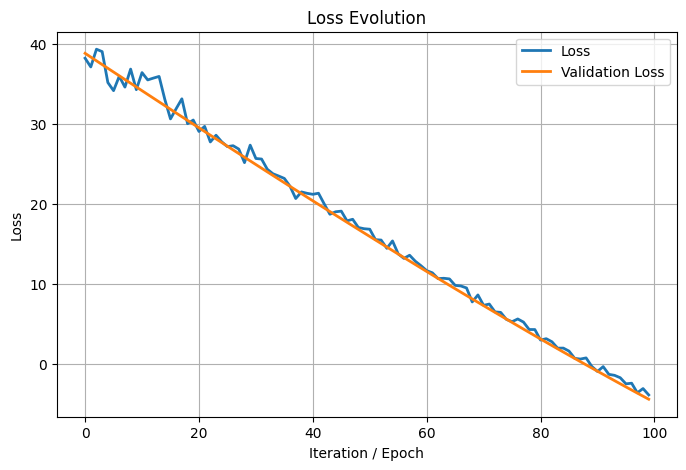

In [9]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

24 24
tensor([-10.0455,   1.5451,   1.5456,   1.5489,   1.5493,   1.8037,   2.1966,
          2.1990,   2.3853,   1.6411,   1.6411,   1.6411, -10.0710,   1.5208,
          1.5223,   1.5194,   1.5270,   1.8417,   2.2120,   2.1148,   1.1074,
          2.6081,   1.6411,   1.6411])


In [11]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [12]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [13]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [14]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [15]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [16]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.3454
KLD Gaussian Train Data:  0.1044
KLD Copula   Train Data:  -0.0002
KLD GTM      Test  Data:  0.3714
KLD Gaussian Test  Data:  0.1091
KLD Copula   Test  Data:  0.0009


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [17]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

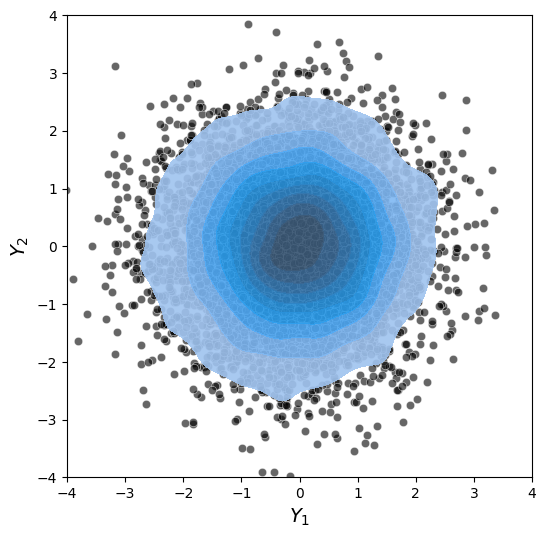

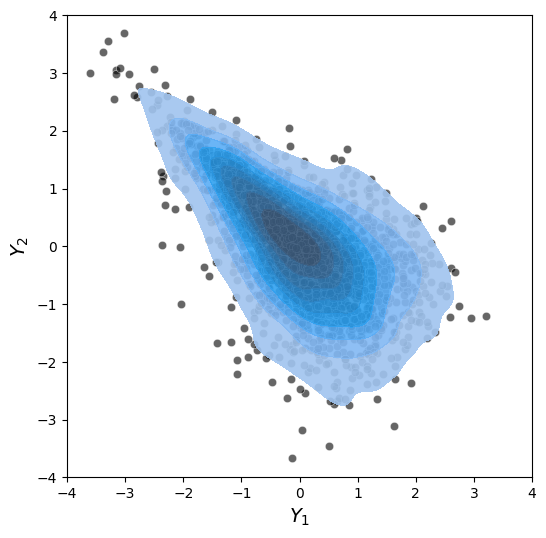

In [18]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [19]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


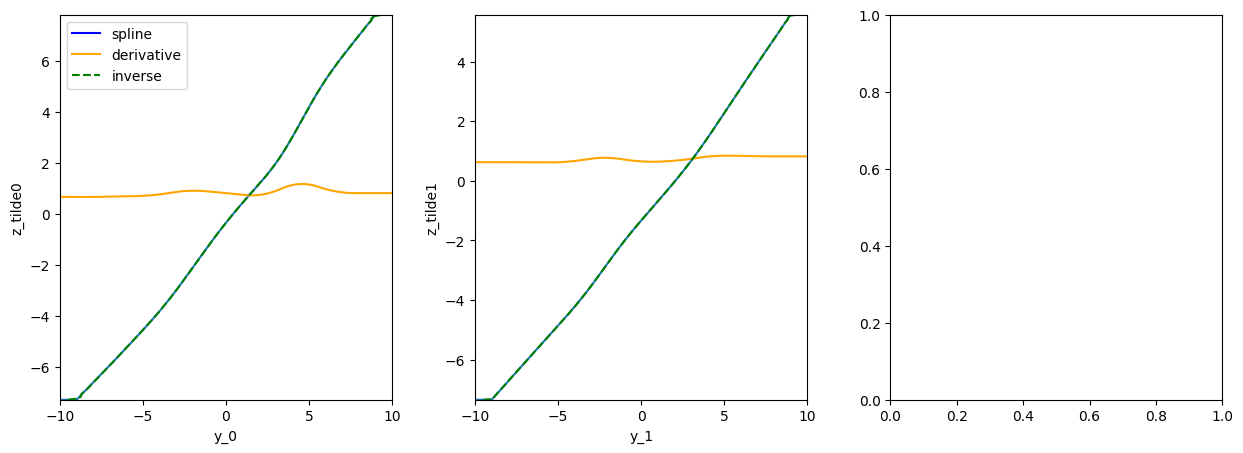

In [ ]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


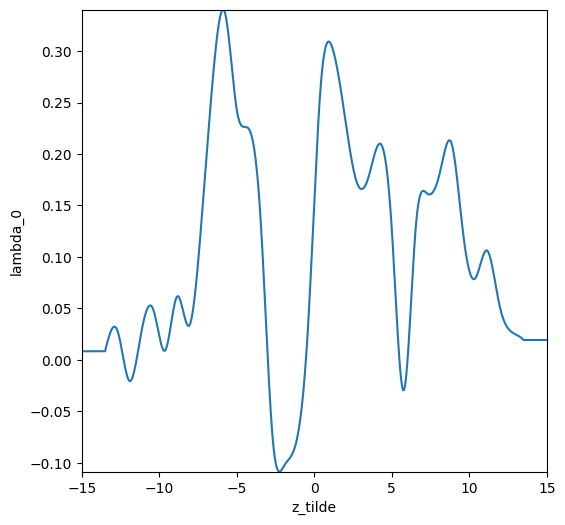

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


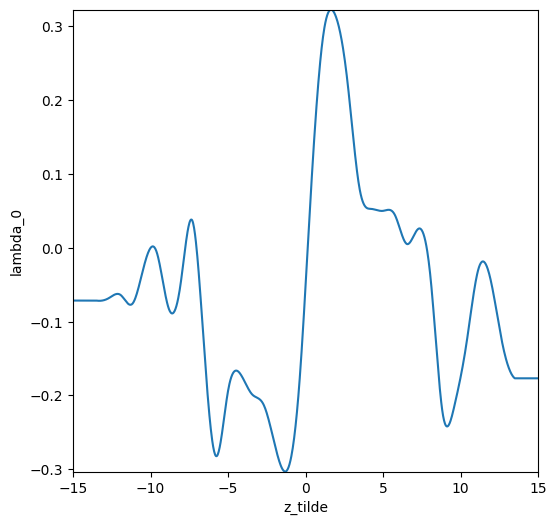

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


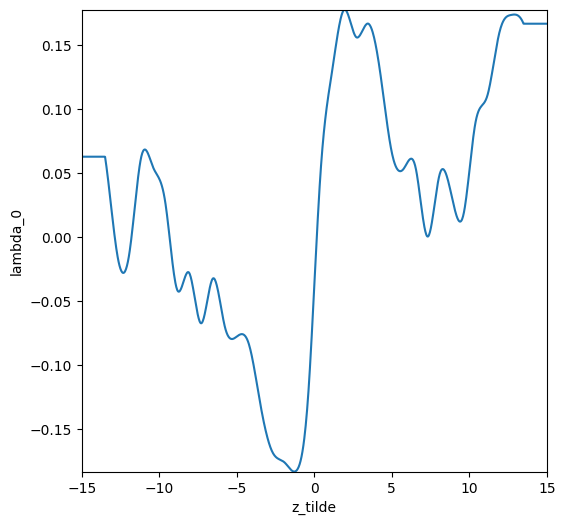

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)